In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import math
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn import init
import torchvision
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torch.utils.data import sampler
from torch.autograd import Variable
from torch.nn import functional as F
from torchvision import datasets, transforms
from s4d import S4D

device = "cuda" if torch.cuda.is_available() else "cpu"

In [2]:
# MAKING THE S4 ARCHITECTURE

if tuple(map(int, torch.__version__.split('.')[:2])) == (1, 11):
    print("WARNING: Dropout is bugged in PyTorch 1.11. Results may be worse.")
    dropout_fn = nn.Dropout
if tuple(map(int, torch.__version__.split('.')[:2])) >= (1, 12):
    dropout_fn = nn.Dropout1d
else:
    dropout_fn = nn.Dropout2d



class VAE_SSM(nn.Module):

    def __init__(
        self,
        d_input,
        d_output=10,
        d_model=400,
        n_layers=4,
        dropout=0.2,
        prenorm=False,
    ):
        super().__init__()

        self.prenorm = prenorm

        # Linear encoder (d_input = 1 for grayscale and 3 for RGB)
        self.encoder = nn.Linear(d_input, d_model)

        # Stack S4 layers as residual blocks
        self.s4_layers = nn.ModuleList()
        self.norms = nn.ModuleList()
        self.dropouts = nn.ModuleList()
        for _ in range(n_layers):
            self.s4_layers.append(
                S4D(d_model, dropout=dropout, transposed=True, lr=min(0.001, 0.01))
            )
            self.norms.append(nn.LayerNorm(d_model))
            self.dropouts.append(dropout_fn(dropout))

        # input: (N, d_model) -> output: (N, d_model) : mean_layer
        self.mean_layer = nn.Linear(in_features = d_model, out_features = d_model)

        # input: (N, d_model) -> output: (N, d_model) : logvar_layer
        self.logvar_layer = nn.Linear(in_features = d_model, out_features = d_model)

        # Linear decoder
        self.decoder = nn.Sequential(
            nn.Linear(d_model, d_input),
            nn.Sigmoid())
        #self.channel_reducer = nn.Linear(d_model, 1)
        self.d_output = d_output


    def forward(self, x):
        """
        Input x is shape (B, L, d_input)
        """
        #x /=255 #Normalizing
        x = self.encoder(x)  # (B, L, d_input) -> (B, L, d_model)

        x = x.transpose(-1, -2)  # (B, L, d_model) -> (B, d_model, L)
        #print("X shape",x.shape)
        for layer, norm, dropout in zip(self.s4_layers, self.norms, self.dropouts):
            # Each iteration of this loop will map (B, d_model, L) -> (B, d_model, L)

            z = x
            if self.prenorm:
                # Prenorm
                z = norm(z.transpose(-1, -2)).transpose(-1, -2)

            # Apply S4 block: we ignore the state input and output
            #print(z.shape)
            z, _ = layer(z)

            # Dropout on the output of the S4 block
            z = dropout(z)

            # Residual connection
            x = z + x

            if not self.prenorm:
                # Postnorm
                x = norm(x.transpose(-1, -2)).transpose(-1, -2)

        x = x.transpose(-1, -2)

        # Pooling: average pooling over the sequence length
        #x = x.mean(dim=1)

        encoder_output = x
        x/=255 # normalize after encoder
        mu = self.mean_layer(encoder_output)
        logvar = self.logvar_layer(encoder_output)

        z = self.reparametrize(mu, logvar)

        # Decode the outputs
        #print(x.shape)
        x_hat = self.decoder(z)  # (B, d_model) -> (B, d_output)

        return x_hat, mu, logvar
    
    @staticmethod
    def loss_function(x_hat, x, mu, logvar):
        """
        Loss function 
        """
        KL_loss = 1 + logvar - mu**2 - torch.exp(logvar)
        KL_loss = -0.5 * KL_loss.sum()
        reconstruction_loss = nn.functional.binary_cross_entropy(x_hat, x, reduction='sum')
        loss = reconstruction_loss + KL_loss
        loss = loss/mu.shape[0]

        return loss
    
    @staticmethod
    def reparametrize(mu, logvar):
        # TODO:
        std = torch.sqrt(torch.exp(logvar))
        eps = torch.rand_like(mu)
        z = mu + (std * eps)
        
        return z

In [3]:
batch_size = 64

transforms = transforms.Compose([
        #transforms.Resize(IMAGE_SIZE),
        transforms.ToTensor(),
        transforms.Lambda(lambda x: x.view(3, 1024).t())
    ])

dataset = torchvision.datasets.CIFAR10(root='dataset/',
                                        train=True,
                                        transform=transforms,
                                        download=True)

dataloader = DataLoader(dataset=dataset, 
                         batch_size=batch_size,
                         shuffle=True)

test_dataset = torchvision.datasets.CIFAR10(root='dataset/',
                                      train=False,
                                      transform=transforms,
                                      download=True)

test_dataloader = DataLoader(test_dataset, batch_size, False)

Files already downloaded and verified
Files already downloaded and verified


In [4]:
print('==> Building generator..')
vae = VAE_SSM(d_input=3,
d_output=784,
d_model=256,
n_layers=12,
dropout=0.2,
prenorm=False,
).to(device)

N, in_channels, H, W = 8, 3, 64, 64
noise_dim = 100
x = torch.randn((256, 1024, 3)).to(device)
x_hat, mu, logvar = vae(x)
print("X_hat", x_hat.shape)

==> Building generator..
X_hat torch.Size([256, 1024, 3])


In [5]:
n_epochs = 4
optimizer = torch.optim.Adam(vae.parameters(), lr = 0.001) 
for epoch in range(n_epochs):
    vae.train()
    train_loss = 0
    loss = None
    for data, labels in dataloader:
        #TODO
        data = data.to(device)
        #data = data / 255.0
        optimizer.zero_grad() # clear the gradients of all optimized variables
        output, mu, logvar = vae(x = data) # forward pass:
        #print(data.shape)
        data = data.reshape(data.shape[0], 3, 32, 32)
        output = output.reshape(output.shape[0], 3, 32, 32)
        loss = VAE_SSM.loss_function(output, data, mu, logvar) # calculate the loss using the loss function defined above
        loss.backward() # backward pass: compute gradient of the loss with respect to model parameters
        optimizer.step() # perform a single optimization step (parameter update)
        train_loss += loss.item() # update running training loss
    train_loss = train_loss/len(dataloader)
    print('Epoch: {} \tTraining Loss: {:.6f}'.format(epoch, train_loss))

Epoch: 0 	Training Loss: 2001.332281


KeyboardInterrupt: 

In [ ]:
torch.save(vae.state_dict(), 'cifar_s4vae.pth')
print("Save successful!")

Save successful!


In [ ]:
from PIL import Image
def detransform(transformed_img):
    original_image = transformed_img.t().view(3, 1024, -1) 
    original_image = original_image.view(3, 32, 32)
    original_image = original_image.cpu().numpy().transpose((1,2,0))
    return original_image

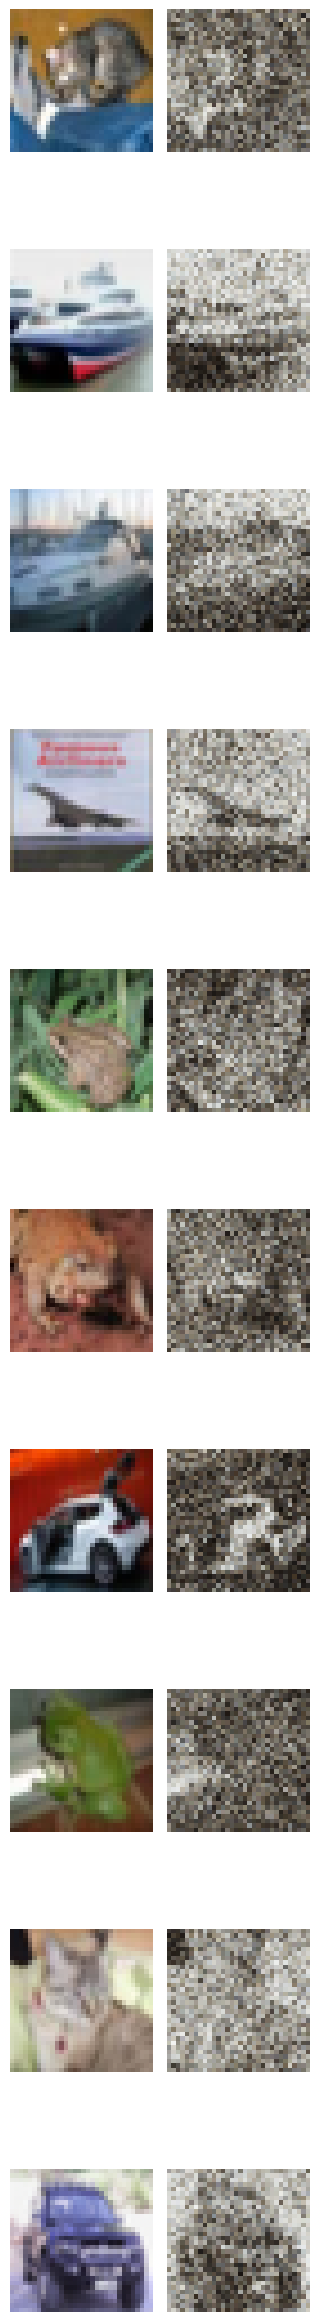

In [ ]:
#plotting original images
dataiter = iter(test_dataloader)
input, labels = next(dataiter)

try_imgs = input[0:10]
fig, axs = plt.subplots(10, 2, figsize=(30, 30))
for i in range(10):
    img = detransform(try_imgs[i])
    out, _, _ = vae(try_imgs[i].to(device))
    out_img = detransform(out.detach())

    axs[i, 0].imshow(img)
    axs[i, 0].axis('off')
    axs[i, 1].imshow(out_img)
    axs[i, 1].axis('off')
plt.subplots_adjust(left=0.5, right=0.6, top=0.9, bottom=0.1, hspace=0, wspace=0.1)

